In [2]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
import geopandas as gpd
import os, math
from matplotlib import pyplot as plt

In [11]:
vn_reservoirs_path = 'vnreservoirs/VN_Reservoirs.shp'
df = gpd.read_file(vn_reservoirs_path)
plt.rcParams['figure.figsize'] = 7,7
ho_tri_an = df[df.AREA_SKM == 277.4]

## Find Rectangle that can bound!

In [58]:
from utils.landsatHepers import *

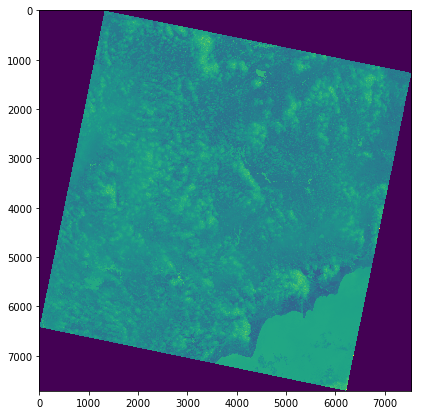

In [104]:
# landsat_title = 'LC08_L1TP_124052_20170311_20170317_01_T1'
landsat_title = 'LC08_L1TP_124052_20170530_20170615_01_T1'
geotiffPath = 'Landsat8/' + landsat_title + '/'
NDWI = rasterio.open(geotiffPath + landsat_title + '_NDWI2.TIF')
ndwi, original_transform = getMaskFromShape(ho_tri_an, NDWI, eps=2000)
pyplot.imshow(NDWI.read(1).squeeze())

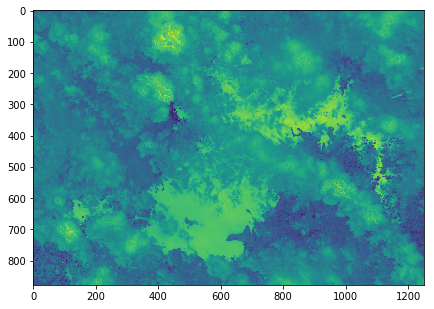

In [105]:
pyplot.imshow(ndwi)

## Segmentation based on BFS

In [106]:
_ndwi = ndwi
for x in range(_ndwi.shape[0]):
    for y in range(_ndwi.shape[1]):
        _ndwi[x,y] = (-1 if _ndwi[x,y] < 0 else 1)

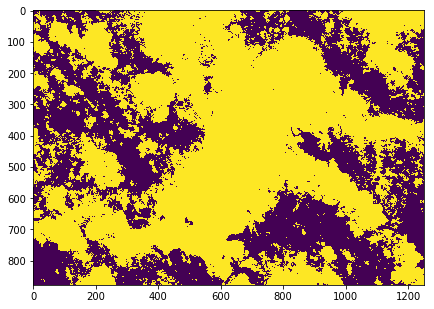

In [107]:
pyplot.imshow(_ndwi)

Area = 507.501


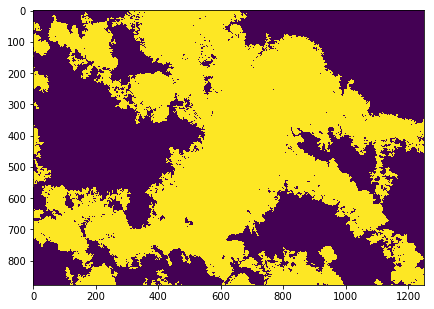

In [108]:
area, segment_array = countPixel(_ndwi, 'NDWI', [600, 600])
print("Area = {0}".format(area * 900 / 1000000))
pyplot.imshow(segment_array)

Normalize Segmented file

In [93]:
segment_array = normalizePixelOnBoundaries(segment_array)

## Find Boundaries of Image

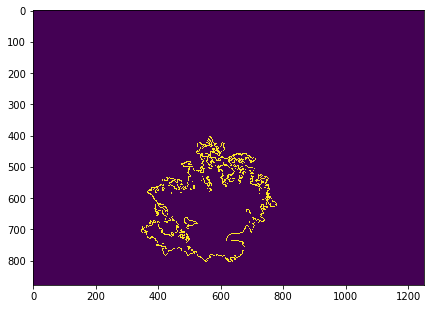

In [94]:
boundaries_array = findBoundariesFromSegmentedArray(segment_array)
plt.imshow(boundaries_array)

Depends all boundaries found, choose the most similar to original.

In [95]:
__shape = getMostSimilarShape(boundaries_array, original_transform, ho_tri_an)

## Try to convert to original coordinates and Masking

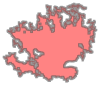

In [96]:
new_shape_in_original_coordinates = [transform_geom(NDWI.crs, df.crs, mapping(__shape))]
_new_shape = shape(new_shape_in_original_coordinates[0])
_new_geom = mapping(_new_shape)
_new_shape = [transform_geom(ho_tri_an.crs, NDWI.crs, _new_geom)]
shape(new_shape_in_original_coordinates[0])

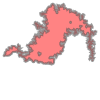

In [97]:
ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(ho_tri_an.crs, NDWI.crs,ho_tri_an_geom)]
ho_tri_an.geometry.values[0]